<img src="../images/ObjectDetection/2-1.jpg" >

> Girshick R, Donahue J, Darrell T, et al. Rich feature hierarchies for accurate object detection and semantic segmentation[C]//Proceedings of the IEEE conference on computer vision and pattern recognition. 2014: 580-587.

# 论文概述

本文是计算机视觉目标检测领域的奠基作，**两阶段目标检测**的开山之作, 提出了`R-CNN`模型，指定了一类目标检测流程的范式，后期目标检测的算法都受其影响。

- `R-CNN`中的**R**为**region**，即目标检测候选框的意思。名字直接告诉我们，该工作就是对候选框进行`CNN`操作，提取出其特征，再对特征进行分类等处理.

- `R-CNN`提出对候选框进行**偏移调整**，用一个回归模型提高候选框框中物体的能力.

- 在标记数据较为匮乏时, 使用监督学习在辅助数据集上进行训练, 然后在特定区域进行微调, 大幅度提升性能表现.

- 此外，`R-CNN`研究提出将卷积神经网络提取特征的可视化，属于深度神经网络的可解释性研究.

<img src="../images/ObjectDetection/2-2.jpg" >

## 算法步骤

<img src="../images/ObjectDetection/3-6.jpg" width=800>
<img src="../images/ObjectDetection/3-7.png">

1. 一张图片生成1K~2K个**候选区域region proposals**
        
      利用`Selective Search`, 算法通过图像分割的方法得到一些原始区域，然后使用一些合并策略如颜色,纹理,相似度等指标,将这些区域合并，得到一个**层次化的区域结构**，而这些结构就包含着可能需要的物体。
<img src="../images/ObjectDetection/2-7.jpg" width="600">

2. 对每个候选区域, 使用深度网络**提取特征**

    将2000个候选区域缩放到227x227像素，接着将候选区域输入事先训练好的`AlexNet CNN`网络获取4096维的特征得到2000×4096维矩阵。
    <img src="../images/ObjectDetection/2-3.jpg" width=500>
    
    - **缩放策略:作者选择<连带邻近像素(16px)+非等比例缩放>策略**
    <img src="../images/ObjectDetection/2-8.jpg">
   
   - **可视化使得某个feature map的某个值最大化的原始候选框可视化**
    <img src="../images/ObjectDetection/2-9.jpg">

3. 特征送入每一类**SVM分类器**, 判别是否属于该类

    将2000×4096维特征与20个SVM组成的权值矩阵4096×20相乘，获得2000×20维矩阵表示每个建议框是某个目标类别的得分。
    <img src="../images/ObjectDetection/2-4.jpg">
    
    分别对上述2000×20维矩阵中每一列即每一类进行**非极大值抑制**剔除重叠建议框，得到该列即该类中得分最高的一些建议框。

> **非极大值抑制**(Non-Maximum Suppression,NMS)剔除重叠建议框:
> 1. 根据置信度得分进行排序
> 2. 选择置信度最高的比边界框添加到最终输出列表中，将其从边界框列表中删除
> 3. 计算所有边界框的面积
> 4. 计算**置信度最高的边界框与其它候选框的IoU**。
> 5. **删除IoU大于阈值(重叠率)的边界框**
> 6. 重复上述过程，直至边界框列表为空。

> 为什么不使用端到端的Softmax,而选择线性SVM分类器?
>
> 答: 1. CNN softmax与SVM训练时的正负样本的选择策略不同, 这会导致CNN softmax的输出比采用svm的精度低.
    > - **Fine Tuning时与GT的IoU最大且IoU大于0.5的候选框为正样本。其余候选框为负样本**。
    > - **训练各类别SVM分类器时，GT框为该类正样本，与GT的IoU小于0.3的候选框为该类负样本，忽略与GT的IoU大于0.3的候选框.**
    > 2. SVM训练时引入了`难负例样本挖掘算法Hard Negative Mining`方法, 用途就是解决正负例数量不均衡，而负例分散代表性又不够的问题.
    > - 每次把那些顽固的棘手的错误的负样本(损失值比较大的负样本，即那些容易误判成正样本的负样本),再送回去继训练,练到模型的效果不再提升为止, 使得分类器的训练结果更好。
    > 3. CNN softmax模型的分类识别能力比较强，鲁棒性会更强（泛化能力更强，也就是对于区域中仅包含部分轮廓的情况，也可以产生一个当前类别的预测），对于精准的定位效果就不会特别的好。
    > 4. R-CNN中输入的是经过resize操作之后的候选框图像，图像存在大量的信息失真的情况，所以单独使用Softmax的分类效果不佳.
    > 5. R-CNN使用Mathlab实现的原因.

4. 使用回归器**精细修正**候选框位置

    对NMS处理后剩余的建议框进一步筛选。接着分别用20个回归器对上述20个类别中剩余的建议框进行回归操作，最终得到每个类别的修正后的得分最高的`bounding box`。**IoU阈值0.6(>0.6)才进行训练**
    <img src="../images/ObjectDetection/2-12.jpg">


## AlexNet简介

### 原理

`AlexNet`是第一个现代深度卷积网络模型，赢得了 2012 年 `ImageNet` 图像分类竞赛的冠军.其首次使用了很多现代深度卷积网络的技术方法.
- 使用 `GPU` 进行并行训练
- 采用 `ReLU` 作为非线性激活函数
- 使用两种正则化技术
    - `Dropout` 防止过拟合.(F9层和F10层,`Dropout`=50％)
    - 使用`数据增强`(随机变换训练图像的各种偏置量,水平翻转以及更改亮度条件)人为地增加训练集的大小,减少过拟合,来提高模型准确率等.<img src="../images/other/14-12.png" width="400">


<img src="../images/other/14-10.png" >

| 层 | 类型 | 特征图 | 大小 | Kernel size | Stride |Padding| 激活函数 |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| Out | Fully connected | - | 1,000 | - | - | - | Softmax |
| F10 | Fully connected | - | 4,096 | - | - | - | ReLU |
| F9 | Fully connected | - | 4,096 | - | - | - | ReLU |
| S8 | Max pooling | 256 | 6x6 | 3x3 | 2 | valid | - |
| C7 | Convolution | 256 | 13x13 | 3x3 | 1 | same | ReLU |
| C6 | Convolution | 384 | 13x13 | 3x3 | 1 | same | ReLU |
| C5 | Convolution | 384 | 13x13 | 3x3 | 1 | same | ReLU |
| S4 | Max pooling | 256 | 13x13 | 3x3 | 2 | valid | - |
| C3 | Convolution | 256 | 27x27 | 5x5 | 1 | same | ReLU |
| S2 | Max pooling | 96 | 27x27 | 3x3 | 2 | valid | - |
| C1 | Convolution | 96 | 55x55 | 11x11 | 4 | valid | ReLU |
| In | Input | 3 (RGB) | 227 x227 | - | - | - | - |

<img src="../images/other/14-11.png">

- `局部响应归一化LRN`

`AlexNet`在C1层和C3层的`ReLU`之后立即使用归一化步骤,成为`局部响应归一化LRN`:最强激活的神经元会抑制位于相邻特征图中相同位置的其他神经元.鼓励不同的特征图专业化,将它们分开,并迫使他们探索更广泛的特征,从而最终改善其泛化能力.

`局部响应归一化`和`层归一化`都是对同层的神经元进行归一化.不同的是,`局部响应归一化`应用在激活函数之后,只是对邻近的神经元进行局部归一化,并且不减去均值.

>假设一个卷积层的输出特征映射 $\boldsymbol{Y} \in \mathbb{R}^{M^{\prime} \times N^{\prime} \times P}$ 为三维张量, 其中每个切片 矩阵 $\boldsymbol{Y}^{\  \ p} \in \mathbb{R}^{M^{\prime} \times N^{\prime}}$ 为一个输出特征映射, $1 \leq p \leq P$.
局部响应归一化是对邻近的特征映射进行局部归一化.
$$
\begin{aligned}
\hat{{Y}}^{p} &=\frac{\boldsymbol{Y}^{\ \ p} }{\left(k+\alpha \sum_{j=\max \left(1, p-\frac{n}{2}\right)}^{\min \left(P, \frac{n}{2}\right)}\left(\boldsymbol{Y}^{\ \ j}\right)^{2}\right)^{\beta}} \\
& \triangleq \operatorname{LRN}_{n, k, \alpha, \beta}\left(\boldsymbol{Y}^{\ \ p}\right),
\end{aligned}
$$

其中除和幕运算都是按元素运算, $n, k, \alpha, \beta$ 为超参, $n$ 为局部归一化的特征窗口 大小. 在 `AlexNet` 中, 这些超参的取值为 $n=5, k=2, \alpha=10 \mathrm{e}^{-4}, \beta=0.75$.


`AlexNet`的变体`ZF Net`实质上是`AlexNet`带有一些结果调整的超参数.

`AlexNet`中每个池化层之后都有`LRN`。归一化层的目的是避免随着层级的加深而导致的信息出现逐层递减的趋势，起到加快神经网络收敛速度的作用。但是，近些年来的研究表明，`LRN`对神经网络的训练过程起到的帮助很小，所以就渐渐不再被使用了。

## 消融实验

- 由于当时目标检测数据集较少,因此作者先在ImageNet数据集上预训练数据集,然后再迁移微调到VOC数据集上.
<img src="../images/ObjectDetection/2-13.jpg" width=400>
    
    下图展示了作者在实验阶段,分别使用`无fine-tuning`,`加上fine-tuning`和`传统DPM方法`的目标检测平均准确率.

<img src="../images/ObjectDetection/2-10.jpg" >

- 作者对对象特征的敏感性进行了实验.

<img src="../images/ObjectDetection/2-11.jpg" >

- 除了目标检测外,在语义分割领域取得了不错的成绩.

## 算法评价

### 与传统算法的比较

<img src="../images/ObjectDetection/3-5.jpg" width="600px">

- 相同之处：

    1. 都对输入图片采用Selective Search进行可能的ROI（Region Of Interest）提取。
    2. 分类器都采用SVM进行分类。
    3. 都采用NMS非极大值抑制方式筛选最终检测结果。

- 不同之处：
    1. R-CNN采用卷积+池化+全连接层的特征提取方式替代了传统目标检测的Hog/LBP特征向量。
    2. R-CNN加入了Bounding box回归操作。（因为传统的目标检测的边框获取来自于Selective Search阶段产生的边框，存在误差需要进一步修正的问题，而R-CNN采用Bounding box回归操作可以进一步对边框的大小和位置信息进行修正和优化。）

### 算法劣势

1. 测试速度慢

        测试一张图片约53s(CPU)。用Selective Search算法提取候选框用时约2秒，一张图像内候选框之间存在大量重叠，提取特征操作冗余。

2. 训练速度慢

        过程极其繁琐.提出的模型包括多个模块，每个模块都是相互独立的，训练也是分开的.下图可与观察到实现消耗主要集中还在候选区域选择,裁切缩放以及CNN特征提取,对于类别多少影响不大.
<img src="../images/ObjectDetection/2-6.jpg" width="600px">

3. 训练所需空间大

        对于SVM和bbox回归训练，需要从每个图像中的每个目标候选框提取特征，并写入磁盘。对于非常深的网络，如VGG16，从V0C07训练集上的5k图像上提取的特征需要数百GB的存储空间。

### 改进R-CNN

- 提取候选框:EdgeBoxes、RPN网络
- 共享卷积运算:SPPNet、Fast R-CNN
- 兼容任意尺寸图像:SPP、ROI Pooling
- 预设长宽比:Anchor
- 网络结构:端到端
- 融合各层特征:FPN

# 论文精读

## 摘要

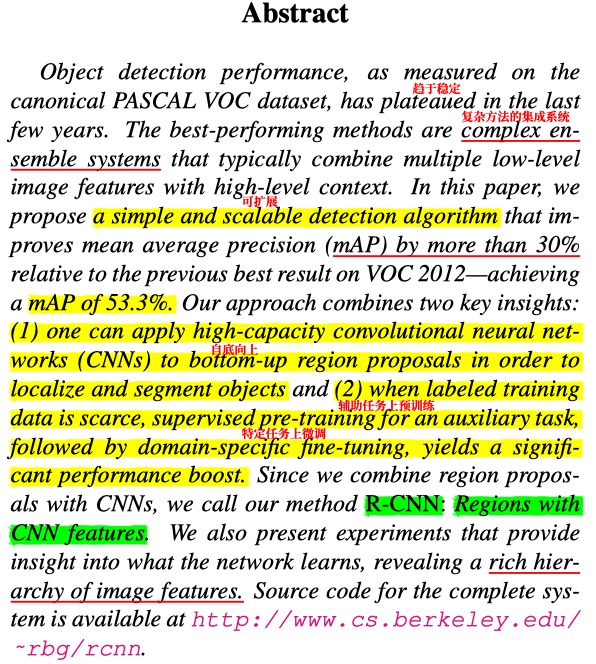

## 引言

特征很重要!过去各种视觉识别任务的进展很大程度上基于SIFT和HOG的使用。但近几年进展缓慢，主要是通过构建集成系统获得微小的效果提升.SIFT和HOG是基于团块、方向上的空间像素信息, 属于比较初级的特征信息, 而基于生物学的识别过程中,下游分层、多阶段过程对视觉识别更具有信息性.

接下来,作者介绍了神经网络的发展历程.AlexNet的大放异彩使得CNN重回历史舞台.对于ImageNet的CNN分类结果可以多大程度推广到VOC挑战数据集上这个讨论, 作者给出了明确的回答,并用填补了图像分类和对象检测之间的鸿沟.

1. 使用深度网络进行目标定位

    与图像分类不同，目标检测需要在图像中定位很多对象。传统可以将目标检测问题视为`回归问题`(后续YOLO系列)或`滑动窗口检测`.但是前者检测效果较差,后者为了保持高的空间分辨率,只能使用较浅的神经网络.

        在RCNN中,卷积层、下样层变多,最后输出的特征图的一个值对应原图的感受野和步长都大.因此也不适合用滑动窗口在大分辨率图像上定位.
    作者采用了`两阶段提取`的范式:我们的方法为输入图像生成大约 2000 个与类别无关的候选区域，使用 CNN 从每个候选区域中提取固定长度的特征向量，然后使用特定于类别的线性 SVM 对每个区域进行分类。我们使用一种仿射图像变形对来自每个候选区域图像进行缩放,使其具有固定大小的 CNN 输入。
    <img src="../images/ObjectDetection/2-2.jpg" >

2. 仅使用少量标记的目标检测数据来训练模型

    传统方法是使用无监督预训练模型,再用监督训练微调.作者采用了在辅助任务上预训练，然后在特定任务上微调的范式，可以显着提升性能.RCNN耗时来源Selective Search产生候选框(2s),CNN逐一提取候选框feature(50s) (存在大量重复计算).非端到端各组件需单独训练.
    
    使用检测分析工具的结果证明了使用边界框回归方法显着减少了错误定位.在语义分割任务上也表现出当时较好的结果.

## 使用 R-CNN 进行目标检测

### 模型设计

**1. 提取候选框**

使用`seletive search`方法提取候选框,以控制变量方便与其他方法进行比较.算法通过聚类产生一些原始区域，然后使用一些合并策略如颜色,纹理,相似度等指标,将这些区域合并，得到一个**层次化的区域结构**，而这些结构就包含着可能需要的物体。
<img src="../images/ObjectDetection/2-7.jpg" width="600">

**2.候选框特征提取**

使用`AlexNet`作为特征提取的骨干网络, 从每个候选框中提取4096维的特征向量.为了计算候选框的特征，必须首先将该区域中的图像数据转换为与 CNN 兼容的大小.作者采用`连带邻近像素(16px)+非等比例缩放`策略.

### 耗时分析

测试阶段使用`seletive search`的快速模式进行检测,为每个候选框进行CNN前向传播.对于每个类使用线性SVM对每个候选框计算置信度,并应用非极大抑制方法.运算时间上看GPU 上的 13 秒每图像或 CPU 上的 53 秒每图像(RCNN仍然是很慢的算法,因为需对2K个预测框逐一提取特征).分析表明，由于矩阵乘法效率高, R-CNN可以扩展到数千个对象类别而保证计算速度没有大幅度的增长.

### 训练

**1. 有监督预训练**

在大型辅助数据集`ILSVRC 2012`上,使用Caffee库对CNN进行了判别式预训练.

**2. 迁移学习微调**

为了使CNN适应新任务和新图像域,继续对VOC变形候选区域进行进行随机梯度下降 (SGD) 训练:**改变最后一层分类层为21(N+1)个类别**,其他不变动并训练所有参数.

微调时与GT的IoU最大且IoU大于0.5的候选框为正样本。其余候选框为负样本。

SGD学习率为0.001,是预训练的十分之一.在每次 SGD 迭代中，进行的统一非均匀采样**batch_size为128的小批量样本,其中32个正样本,96个负样本.**这样因为正负样本不均衡.

**3. 类别分类器**

对于部分重叠样本的分类, 作者通过网格搜索遍历IoU阈值,得出0.3时效果最好.作者将GT简单的设置成正样本.

由于训练数据太大无法放到内存, 作者采用了`hard negative mining method`(错题本)

### VOC上的结果

该方法在 mAP 方面取得了很大的进步，从 35.1% 提高到 53.7%，同时速度也快得多.

## 可视化、消融对照实验和错误模式分析

### 可视化学习特征

把所有一千万个候选框输入, 找到能使某个feature map中的某个值产生最大激活的候选框, 也就是使某单次卷积，单个神经元产生最大激活的候选框.

不对整个feature map求平均只关注feature map中的某个值.

<img src="../images/ObjectDetection/2-9.jpg">

### 消融对照实验

<img src="../images/ObjectDetection/2-10.jpg" >

**1. 预训练性能,不进行微调**

$FC_7$没有用处,预训练模型的性能来自于卷积层而不是全连接层.研究表面, 仅使用CNN的卷积层在计算任意大小图像的密集特征图方面具有潜在的实用性.

**2. 预训练性能,进行微调**

微调带来的提升要明显,研究表明从 ImageNet 中学习到的特征是通用的，并且大部分改进是通过在它们之上学习特定领域获得的的非线性分类器.

总的来说,预训练提取卷积层特征,微调全连接层提取特定领域分类器.

**3. 传统方法对比**

R-CNN提升明显

### 错误模式分析

**1.误报 (fp) 类型的分布**

R-CNN的错误明显更多是由于定位不佳造成的，而不是与背景或其他对象类混淆.
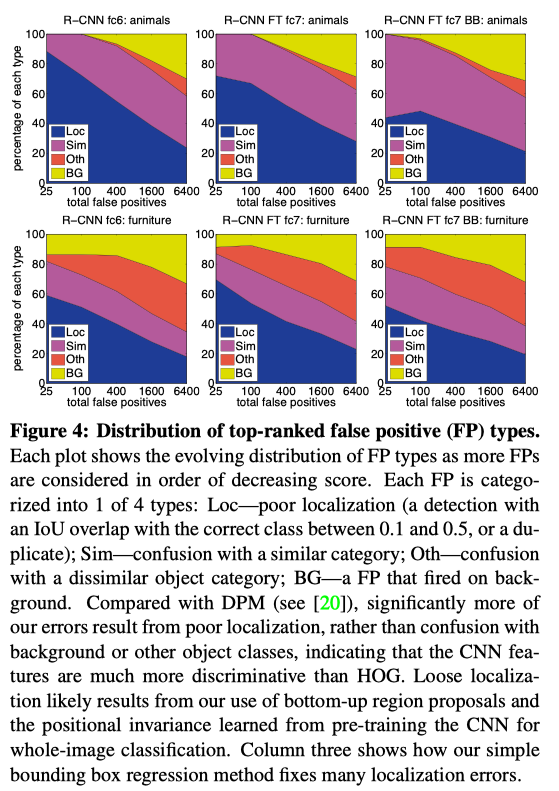

**2. 对物体特征的敏感性分析**

微调不会降低灵敏度（最大值和最小值之间的差异），但会显着改善几乎所有特征的最高和最低性能。这表明微调不仅仅是改善纵横比和边界框区域的性能最低的子集。相反，微调提高了所有特征的鲁棒性，包括遮挡、截断、视点和零件可见性。

### 预测框回归

训练了一个线性回归模型来预测一个新的检测窗口.对NMS处理后剩余的建议框进一步筛选。接着分别用20个回归器对上述20个类别中剩余的建议框进行回归操作，最终得到每个类别的修正后的得分最高的`bounding box`。
    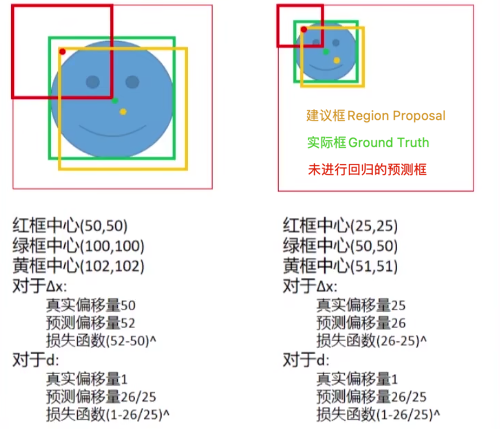
    <img src="../images/ObjectDetection/2-12.jpg" width=500>


## 语义分割

第一种策略忽略区域的形状并直接在候选框上计算 CNN 特征，类似于目标检测.这会导致两个区域可能具有非常相似的边界框，而重叠很少;第二种策略 仅在区域的前景上计算 CNN 特征;第三种策略将前景和背景特征连接起来.使用第三种策略, 在VOC 2011 的结果显示实现了最高的分割准确率.

## 结论

近年来，目标检测性能停滞不前。性能最好的系统是复杂的集成，将多个低级图像特征与来自对象检测器和场景分类器的高级上下文相结合。本文提出了一种简单且可扩展的对象检测算法，与 PASCAL VOC 2012 上的最佳先前结果相比，该算法相对改进了 30%。

我们通过两个见解实现了这一性能。第一个是将大容量卷积神经网络应用于自下而上的区域提议，以定位和分割对象。第二个是在标记的训练数据稀缺时训练大型 CNN 的范式。我们表明，对于具有大量数据的辅助任务（图像分类），使用监督预训练网络非常有效，然后针对数据稀缺的目标任务（检测）微调网络。我们推测“有监督的预训练/特定领域微调”范式对于各种数据稀缺的视觉问题将非常有效。

我们最后指出，通过结合使用来自计算机视觉和深度学习的经典工具（自下而上的区域提议和卷积神经网络）来实现这些结果是非常重要的。两者不是对立的科学探究路线，而是自然且不可避免的合作伙伴。

> create:Apotosome 11/03/22

> update:Apotosome 11/03/22